In [37]:
import gc
import torch
from fastai.vision import *
from fastai.widgets import *
from fastai.callbacks import * 
import shutil
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.52
cuda: False


In [38]:
Config.DEFAULT_CONFIG = {
        'data_path': './../data/MURA-v1.1/',
        'model_path': './models/'
    }

Config.create('/tmp/myconfig.yml')
Config.DEFAULT_CONFIG_PATH = '/tmp/myconfig.yml'

path = Config.data_path()

In [39]:
size = 320
bs = 32

np.random.seed(42)
data = ImageDataBunch.from_folder('../data/MURA-v1.1/data2/', ds_tfms=get_transforms(do_flip=True, max_rotate=30, max_warp=0.0, p_lighting=0, xtra_tfms=[cutout(n_holes=(0,3), length=(5,35),p=1)]), size=size, bs=bs).normalize(imagenet_stats)


kappa = KappaScore()
kappa.weights = "quadratic"
# def _corners(x):
#     h,w = x.shape[1:]
#     x[:, 0:40, 0:40] = 0
#     x[:, 0:40, w-40:] = 0
#     x[:, h-40:, 0:40] = 0
#     x[:, h-40:, w-40:] = 0
#     return x
    
# corners = TfmPixel(_corners)
    
# size = (320,320)
# bs = 32

# np.random.seed(42)
# data = ImageDataBunch.from_folder('../data/MURA-v1.1/data2/', ds_tfms=get_transforms(do_flip=True, max_rotate=30, max_warp=0.0, p_lighting=0, xtra_tfms=[cutout(n_holes=(0,3), length=(5,35),p=1)]), size=size, bs=bs).normalize(imagenet_stats)

# # data = ImageDataBunch.from_folder('../data/MURA-v1.1/data2/', ds_tfms=get_transforms(do_flip=True,max_warp=0.0, p_lighting=0, max_rotate=30, xtra_tfms=[corners(p=1)]), size=size, bs=bs).normalize(imagenet_stats)

# kappa = KappaScore()
# kappa.weights = "quadratic"


In [40]:
learner = cnn_learner(data, models.vgg19_bn, metrics=[error_rate, accuracy, kappa], wd=0.1, model_dir="./models/").to_fp32()
# #learner.unfreeze()
# learner.fit_one_cycle(5,max_lr=1e-3, callbacks=[ShowGraph(learner) ,SaveModelCallback(learner)])

learner.load('vgg19bn-onerun-35whole')

Learner(data=ImageDataBunch;

Train: LabelList (36808 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,0,0,0
Path: ../data/MURA-v1.1/data2;

Valid: LabelList (3197 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,0,0,0
Path: ../data/MURA-v1.1/data2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128,

In [41]:
val_preds,val_targets = learner.get_preds() 
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('../data/MURA-v1.1/data2/valid/0/') if isfile(join('../data/MURA-v1.1/data2/valid/0/', f))]
files += [f for f in listdir('../data/MURA-v1.1/data2/valid/1/') if isfile(join('../data/MURA-v1.1/data2/valid/1/', f))]
files[0]

print(len(val_preds))
print(len(files))

studies = []
studies_labels = []
for file in files:
    study = file[:-11]
    if study not in studies:
        studies.append(study)
        if 'negative' in study:
            studies_labels.append(0)
        else:
            studies_labels.append(1)
            
study_actual = dict()
for study in studies:
    if 'negative' in study:
        study_actual[study] = 0
    else:
        study_actual[study] = 1

study_dict = dict()
for study in studies:
    if study not in study_dict:
        study_dict[study] = []
        
file_count = 0
for file in files:
    study = file[:-11]
    study_dict[study].append(float(val_preds[file_count][1]))
    file_count += 1
    
study_preds = dict()
for study in study_dict:
    combined_pr = sum(study_dict[study])/len(study_dict[study])
    if combined_pr >= 0.5:
        study_preds[study] = 1
    else:
        study_preds[study] = 0
        
print(len(study_actual))
print(len(study_preds))

please = 0
for i in study_actual:
    if study_actual[i] == study_preds[i]:
        please += 1
print("By study accuracy: ", please/1200)


#kappa
actual_list = []
pred_list = []
for i in study_actual:
    actual_list.append(study_actual[i])
    pred_list.append(study_preds[i])

p_o = 0
p_e = 0

agreed = 0
for i in range(len(actual_list)):
    if actual_list[i] == pred_list[i]:
        agreed += 1
p_o = agreed/len(actual_list)
print("p_o: ", p_o)

actual_yes = sum(actual_list)/len(actual_list)
pred_yes = sum(pred_list)/len(pred_list)

actual_no = 1-sum(actual_list)/len(actual_list)
pred_no = 1-sum(pred_list)/len(pred_list)

p_e = actual_yes*pred_yes + actual_no*pred_no
print("p_e: ", p_e)

kappa = (p_o-p_e)/(1-p_e)
print("KAPPA BY STUDY: ", kappa)

3197
3197
1200
1200
By study accuracy:  0.8475
p_o:  0.8475
p_e:  0.5111833333333333
KAPPA BY STUDY:  0.6880220941730029


In [42]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

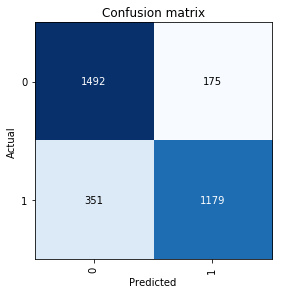

In [43]:
interp.plot_confusion_matrix()

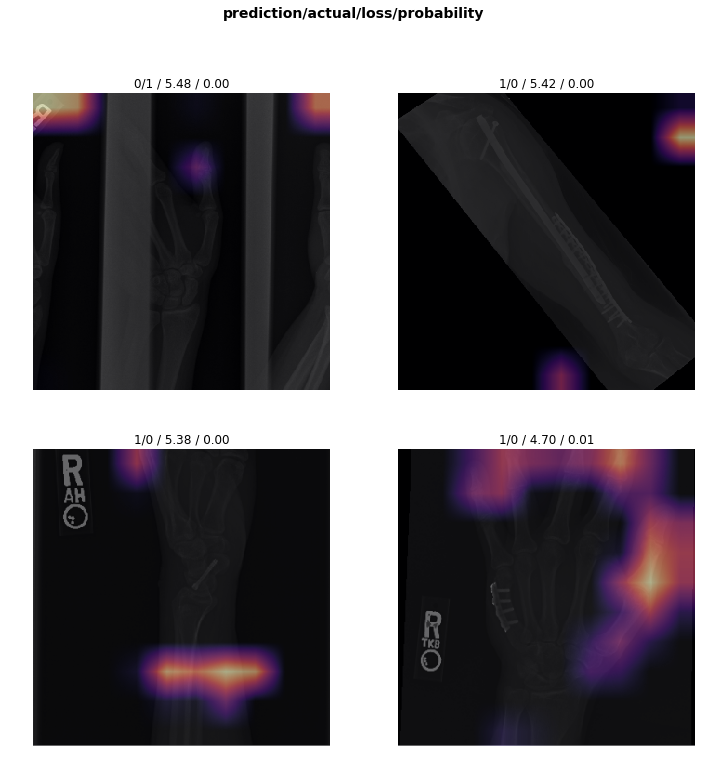

In [52]:
interp.plot_top_losses(4, figsize=(12, 12))

In [8]:
val_preds,val_targets = learner.get_preds() 

In [9]:
print(float(val_preds[0][0]))

0.8696333765983582


In [10]:
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('../data/MURA-v1.1/data2/valid/0/') if isfile(join('../data/MURA-v1.1/data2/valid/0/', f))]
files += [f for f in listdir('../data/MURA-v1.1/data2/valid/1/') if isfile(join('../data/MURA-v1.1/data2/valid/1/', f))]
files[0]

'ELBOW_patient11860_study1_negative_image1.png'

In [11]:
studies = []
studies_labels = []
for file in files:
    study = file[:-11]
    if study not in studies:
        studies.append(study)
        if 'negative' in study:
            studies_labels.append(0)
        else:
            studies_labels.append(1)


In [12]:
# learner.get_preds('../data/MURA-v1.1/data2/valid/0/ELBOW_patient11860_study1_negative_image1.png')

# img = open_image('../data/MURA-v1.1/data2/valid/0/ELBOW_patient11860_study1_negative_image1.png')
# img
# learner.predict(img)

print(len(val_preds))
print(len(files))

3197
3197


In [13]:
study_actual = dict()
for study in studies:
    if 'negative' in study:
        study_actual[study] = 0
    else:
        study_actual[study] = 1
    

In [14]:
study_dict = dict()
for study in studies:
    if study not in study_dict:
        study_dict[study] = []

In [15]:
file_count = 0
for file in files:
    study = file[:-11]
    study_dict[study].append(float(val_preds[file_count][1]))
    file_count += 1

In [16]:
study_preds = dict()
for study in study_dict:
    combined_pr = sum(study_dict[study])/len(study_dict[study])
    if combined_pr >= 0.5:
        study_preds[study] = 1
    else:
        study_preds[study] = 0

In [17]:
print(len(study_actual))
print(len(study_preds))

1200
1200


In [18]:
please = 0
for i in study_actual:
    if study_actual[i] == study_preds[i]:
        please += 1

In [19]:
please/1200

0.83

In [20]:
#kappa
actual_list = []
pred_list = []
for i in study_actual:
    actual_list.append(study_actual[i])
    pred_list.append(study_preds[i])



In [21]:
p_o = 0
p_e = 0

In [22]:
agreed = 0
for i in range(len(actual_list)):
    if actual_list[i] == pred_list[i]:
        agreed += 1
p_o = agreed/len(actual_list)
p_o

0.83

In [23]:
actual_yes = sum(actual_list)/len(actual_list)
pred_yes = sum(pred_list)/len(pred_list)

actual_no = 1-sum(actual_list)/len(actual_list)
pred_no = 1-sum(pred_list)/len(pred_list)

p_e = actual_yes*pred_yes + actual_no*pred_no
p_e

0.5110986111111111

In [24]:
kappa = (p_o-p_e)/(1-p_e)

In [25]:
kappa

0.6522816177995449

In [26]:
bones = ["ELBOW", "FINGER", "FOREARM", "HAND", "HUMERUS", "SHOULDER", "WRIST"]

In [27]:
studies = []
studies_labels = []
for file in files:
    if "WRIST" in file:
        study = file[:-11]
        if study not in studies:
            studies.append(study)
            if 'negative' in study:
                studies_labels.append(0)
            else:
                studies_labels.append(1)

In [28]:
study_actual = dict()
for study in studies:
    if 'negative' in study:
        study_actual[study] = 0
    else:
        study_actual[study] = 1
    

In [29]:
study_dict = dict()
for study in studies:
    if study not in study_dict:
        study_dict[study] = []

In [30]:
file_count = 0
for file in files:
    if "WRIST" in file:
        study = file[:-11]
        study_dict[study].append(float(val_preds[file_count][1]))
    file_count += 1

In [31]:
study_preds = dict()
for study in study_dict:
    combined_pr = sum(study_dict[study])/len(study_dict[study])
    if combined_pr >= 0.5:
        study_preds[study] = 1
    else:
        study_preds[study] = 0

In [32]:
print(len(study_actual))
print(len(study_preds))

237
237


In [33]:
#kappa
actual_list = []
pred_list = []
for i in study_actual:
    actual_list.append(study_actual[i])
    pred_list.append(study_preds[i])


In [34]:
agreed = 0
for i in range(len(actual_list)):
    if actual_list[i] == pred_list[i]:
        agreed += 1
p_o = agreed/len(actual_list)
p_o

0.8860759493670886

In [35]:
actual_yes = sum(actual_list)/len(actual_list)
pred_yes = sum(pred_list)/len(pred_list)

actual_no = 1-sum(actual_list)/len(actual_list)
pred_no = 1-sum(pred_list)/len(pred_list)

p_e = actual_yes*pred_yes + actual_no*pred_no
p_e

0.5294735530274707

In [36]:
kappa = (p_o-p_e)/(1-p_e)
print(kappa)

0.7578796019524007
